## Study of the resulting distributions
In this notebook we want to compare the resulting distributions by applying various statistical methods to quantify differences and similarities.
### 1. Kolmogerov-Smirnov-Test
First of all, we carry out a statistical test to check if the different distributions result from a common underlying distribution. We select the [*Kolmogerov-Smirnov-Test*](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test) to verify this hypothesis.  

The test computes a test statistic $D$ that is compared to a threshold $D_{\alpha}$ with a significance level $\alpha$. If
$$D < D_{\alpha}$$ 
then the two distributions are likely to be similar. If, in contrast, 
$$D \ge D_{\alpha}$$ 
then we can conclude the samples are not from a common distribution with a significance of $1-\alpha$. The test measures the maximum distance of the cumulative distribution functions $F$ of the involved distributions. Accordingly, $D$ is computed by
$$D = \mathrm{max} |( F_{1} - F_{2} )| $$
The threshold can be determined by 
$$D_{\alpha} = K_{\alpha}\sqrt{(n_1+n_2)/(n_1 \cdot n_2)} $$
$K_{\alpha}$ is a constant that is dependent on the significance level $\alpha$ and can be obtained by this table:


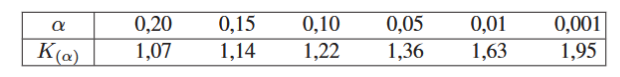

In [1]:
from thesis_schneg.model import DatasetName

##### set visualization configuration #####



# select dataset (if none is selected all datasets are visualized in a joint plot) 
dataset: DatasetName = None 
# dataset: DatasetName = 'aol'
# dataset: DatasetName = 'aql'
# dataset: DatasetName = 'ms-marco'
# dataset: DatasetName = 'orcas'

# plot cleaned aol data or not
cleaned_aol = False
# cleaned_aol = True

struc_level = []
struc_level.append('queries')
struc_level.append('named-entities')
struc_level.append('words')

base_analyses = []
base_analyses.append('character-count-frequencies') #-{struc}
base_analyses.append('word-count-frequencies')
base_analyses.append('entity-count-frequencies')

analyses = []
for item in base_analyses:
    for struc in struc_level:
        if item == 'word-count-frequencies' and struc != 'words':
            analyses.append(f'{item}-{struc}')
        elif item == 'entity-count-frequencies' and struc != 'named-entities' and struc != 'words':
            analyses.append(f'{item}-{struc}')
        elif item == 'character-count-frequencies':
            analyses.append(f'{item}-{struc}')

# test_data = True
test_data = False

normalize_data = True
# normalize_data = False


In [2]:
from thesis_schneg.vis_modules import _get_results_paths, load_results
from pathlib import Path
import time
color = None
label = None
# load data
analysis_data = []
for analysis_name in analyses:
    if dataset is None:
        result_data = {}
        # crawl files from all datasets and load into dictionary
        paths = {f"{name}": _get_results_paths(name, analysis_name, cleaned_aql=True) for name in [
            "aol", "aql", "ms-marco", "orcas"]}
        if analysis_name == 'character-count-frequencies-words' and cleaned_aol:
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aol-words-character-count-frequencies-special")
            paths["aol"] = [path for path in base_path.iterdir(
        )]
        if analysis_name == 'character-count-frequencies-queries':
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-get-char-count-special")
            paths["aql"] = [path for path in base_path.iterdir(
        )]
            
        for name, result_paths in paths.items():
            start_time = time.time()
            print(f"Loading data from {name} dataset")
            vis_data = load_results(result_paths, test_data=test_data)
            result_data.update({name: vis_data})
            end_time = time.time()  
            print(f"{name} loaded in {(end_time - start_time)/60} min")

        analysis_data.append(result_data)
    else:
        # load data from single dataset
        result_paths = _get_results_paths(dataset, analysis_name, cleaned_aql=True)
        if analysis_name == 'character-count-frequencies-words' and cleaned_aol:
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aol-words-character-count-frequencies-special")
            result_paths = [path for path in base_path.iterdir(
        )]
        start_time = time.time()
        print(f"Loading data from {dataset} dataset")
        result_data = {dataset: load_results(result_paths)}
        end_time = time.time()  
        print(f"{dataset} loaded in {(end_time - start_time)/60} min")
        analysis_data.append(result_data)   

/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-queries-special
Loading data from aol dataset
aol loaded in 0.23538933595021566 min
Loading data from aql dataset
aql loaded in 0.37209360202153524 min
Loading data from ms-marco dataset
ms-marco loaded in 0.17004571755727133 min
Loading data from orcas dataset
orcas loaded in 0.17229437430699665 min
/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-named-entities-special
Loading data from aol dataset
aol loaded in 0.10616446733474731 min
Loading data from aql dataset
aql loaded in 0.2245997707049052 min
Loading data from ms-marco dataset
ms-marco loaded in 0.11634835799535116 min
Loading data from orcas dataset
orcas loaded in 0.09977917273839315 min
/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-words-special
L

In [6]:
from thesis_schneg.vis_modules import ks_test, chi2_fit

cnt = 0
for analysis in analysis_data:
    print(analyses[cnt])
    test_data = analysis['aql']
    test_counts = []
    if 'character-count' in test_data.columns:
        # print("character-count")
        test_data = test_data.query('`character-count` > 0')
        test_data = test_data.query('`character-count` < 50').sort_values('character-count', ascending=True)
        test_data = test_data['count()'].to_numpy()
        col = 'character-count'
        max = 50
    elif 'entity-count' in test_data.columns:
        # print("entity-count")
        test_data = test_data.query('`entity-count` >= 0')
        test_data = test_data.query('`entity-count` < 3').sort_values('entity-count', ascending=True)
        test_data = test_data['count()'].to_numpy()
        col = 'entity-count'
        max = 3
    elif 'word-count' in test_data.columns:
        # print("word-count")
        test_data = test_data.query('`word-count` > 0')
        test_data = test_data.query('`word-count` < 8').sort_values('word-count', ascending=True)
        test_data = test_data['count()'].to_numpy()  
        col = 'word-count'
        max = 8
    # print(f"max: {max}")
    for dataset, data in analysis.items():
        if dataset != 'aql':
            exp_counts = []
            if col == 'entity-count':
                exp_data = data.query(f"`{col}` >= 0")
            else:
                exp_data = data.query(f"`{col}` > 0")
            exp_data = exp_data.query(f'`{col}` < {max}').sort_values(col, ascending=True)
            exp_data = exp_data['count()'].to_numpy()
            
            test_statistic, threshold, test_res = ks_test(test_data, exp_data, significance_lvl=0.05)
            print(f"Test AQL vs {dataset.upper()}: ks-test-statistic: {test_statistic} threshold: {threshold} common distribution: {test_res}")
            test_statistic, threshold, test_res = chi2_fit(test_data, exp_data, significance_lvl=0.05)
            print(f"Test AQL vs {dataset.upper()}: chi2-test-statistic: {test_statistic} threshold: {threshold} common distribution: {test_res}")

    

    cnt+=1

character-count-frequencies-queries
Test AQL vs AOL: ks-test-statistic: 0.11173531961695468 threshold: 0.00024166922498427152 common distribution: False
Test AQL vs AOL: chi2-test-statistic: 65750470.63159055 threshold: 65.17076890356984 common distribution: False
Test AQL vs MS-MARCO: ks-test-statistic: 0.12681904097342817 threshold: 0.0004602167429355898 common distribution: False
Test AQL vs MS-MARCO: chi2-test-statistic: 308275880.3753942 threshold: 65.17076890356984 common distribution: False
Test AQL vs ORCAS: ks-test-statistic: 0.2631041848885969 threshold: 0.000430322838737808 common distribution: False
Test AQL vs ORCAS: chi2-test-statistic: 4828928069.247391 threshold: 65.17076890356984 common distribution: False
character-count-frequencies-named-entities
Test AQL vs AOL: ks-test-statistic: 0.08229342045206064 threshold: 0.0012005150337576981 common distribution: False
Test AQL vs AOL: chi2-test-statistic: 2019180.2128319456 threshold: 65.17076890356984 common distribution: F

### 2. Wasserstein Metric
As we can see, the test clearly rejects the distributions being from the same underlying distribution. However, visualizations of the distributions showed that there are similarities. To assess, if the AQL's queries suit to the other realistic query logs, we measure distances between the distributions. The [*Wasserstein-Metric*](https://en.wikipedia.org/wiki/Wasserstein_metric) is a distance function for probability distributions. It satisfies the criteria of actual mathematical metrics and thus enables comparisons between probability distributions. Assuming one-dimensional distributions, the Wasserstein Distance of two empirical samples $P$ and $Q$ with respective random variables $X_1,...,X_n$ and $Y_1,...,Y_n$ is given by:
$$ W_{p}(P,Q)=\left({\frac {1}{n}}\sum _{i=1}^{n}\|X_{(i)}-Y_{(i)}\|^{p}\right)^{\frac {1}{p}}$$ 


In [2]:
from thesis_schneg.model import DatasetName
from thesis_schneg.vis_modules import _get_results_paths, load_results
from pyarrow import compute as pc
from scipy.stats import wasserstein_distance
import numpy as np

struc_level = []
struc_level.append('queries')
struc_level.append('named-Entities')
struc_level.append('words')

base_analyses = []
base_analyses.append('character-count') #-{struc}
base_analyses.append('word-count')
base_analyses.append('entity-count')

analyses = []
for item in base_analyses:
    for struc in struc_level:
        analyses.append(f'{item.lower()}-frequencies-{struc.lower()}')
    del struc_level[-1]

Load data:

In [3]:
from time import time
# load data
analysis_data = {}
for analysis in analyses:
    print(f"Start loading \"{analysis}\"")
    datasets = {}
    for dataset in ["aol","aql","ms-marco","orcas"]:
        start_time = time()
        paths = _get_results_paths(dataset, analysis)
        result_data = load_results(paths)
        datasets.update({dataset: result_data})
        end_time = time()
        print(f"{dataset.upper()} loaded in {(end_time - start_time)/60} min")
    analysis_data.update({analysis: datasets})

Start loading "character-count-frequencies-queries"
AOL loaded in 0.2646281003952026 min
AQL loaded in 0.46156874895095823 min
MS-MARCO loaded in 0.18490427335103352 min
ORCAS loaded in 0.2910810589790344 min
Start loading "character-count-frequencies-named-entities"
AOL loaded in 0.0829898993174235 min
AQL loaded in 0.12900979518890382 min
MS-MARCO loaded in 0.11375235319137574 min
ORCAS loaded in 0.0822432557741801 min
Start loading "character-count-frequencies-words"
AOL loaded in 0.13015028635660808 min
AQL loaded in 0.12984970410664876 min
MS-MARCO loaded in 0.06727551221847534 min
ORCAS loaded in 0.04818233648935954 min
Start loading "word-count-frequencies-queries"
AOL loaded in 0.027992467085520428 min
AQL loaded in 0.029330225785573323 min
MS-MARCO loaded in 0.03716421922047933 min
ORCAS loaded in 0.030470561981201173 min
Start loading "word-count-frequencies-named-entities"
AOL loaded in 0.01754915714263916 min
AQL loaded in 0.0294212539990743 min
MS-MARCO loaded in 0.0191051

Compute Wasserstein Distances:

In [4]:
from thesis_schneg.vis_modules import get_max_x
from numpy import ndarray
from pandas import DataFrame
cnt=0
distances_data = {}
for analysis, datasets in analysis_data.items():
    print(analysis)
    x_max = get_max_x(datasets, f"{analysis.split('-')[0]}-count")
    # print(x_max)
    # distances = ndarray((len(datasets), len(datasets)))
    distances = DataFrame(np.zeros((len(datasets), len(datasets))), index=datasets.keys(), columns=datasets.keys())
    names = []
    j=0
    for dataset_name, data in datasets.items():
        data1 = {dataset_name: data.sort_values(f"{analysis.split('-')[0]}-count", ascending=True)}
        names.append(dataset_name)
        x_vals = data1[dataset_name][f"{analysis.split('-')[0]}-count"][0:x_max]
        y_vals = data1[dataset_name]['count()'][0:x_max]
        i=0
        for dataset_name, data in datasets.items():
            if dataset_name in names:
                dist = 0
            else:
                data2 = data.sort_values(f"{analysis.split('-')[0]}-count", ascending=True)
                x_vals2 = data2[f"{analysis.split('-')[0]}-count"][0:x_max]
                y_vals2 = data2['count()'][0:x_max]
                dist = wasserstein_distance(x_vals, x_vals2, u_weights=y_vals, v_weights=y_vals2)
            # distances[i][j] = dist
            distances.iloc[i, j] = dist
            i+=1
        j+=1
    distances = distances + distances.T
    distances_data.update({analysis: distances})
    cnt+=1
for key, value in distances_data.items():
    print(value)


character-count-frequencies-queries
get x_max...
aol
aql
ms-marco
orcas
character-count-frequencies-named-entities
get x_max...
aol
aql
ms-marco
orcas
character-count-frequencies-words
get x_max...
aol
aql
ms-marco
orcas
word-count-frequencies-queries
get x_max...
aol
aql
ms-marco
orcas
word-count-frequencies-named-entities
get x_max...
aol
aql
ms-marco
orcas
entity-count-frequencies-queries
get x_max...
aol
aql
ms-marco
orcas
               aol       aql  ms-marco    orcas
aol       0.000000  3.978745  2.538909  3.72049
aql       3.978745  0.000000  4.052803  6.98186
ms-marco  2.538909  4.052803  0.000000  2.97772
orcas     3.720490  6.981860  2.977720  0.00000
               aol       aql  ms-marco     orcas
aol       0.000000  2.117574  1.790903  0.795718
aql       2.117574  0.000000  2.849128  1.974193
ms-marco  1.790903  2.849128  0.000000  1.029028
orcas     0.795718  1.974193  1.029028  0.000000
               aol       aql  ms-marco     orcas
aol       0.000000  3.953559  6.309

Visualize Distances by applying [MDS-transformation](https://en.wikipedia.org/wiki/Multidimensional_scaling):

In [ ]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt, use
from pathlib import Path    
import scienceplots

# use science style for plots from scienceplots library
plt.style.use(["science", "grid"])

save_vis = True
# save_vis = False

mds = MDS(n_components=2, dissimilarity='precomputed')
trans_dists = {}
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']
for key, value in distances_data.items():
    print(key)
    trans_dists.update({key: mds.fit_transform(value)})

num_plots = len(trans_dists)
cols = 3
rows = num_plots//cols
if num_plots % cols != 0:
    rows+=1

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

# fig,ax = plt.subplots(rows,cols, figsize=(4*cols,4*rows))
fig,ax = plt.subplots(rows,cols, figsize=(width,height))

# for key, value in trans_dists.items() and ax in ax.flatten():
key = [key for key in trans_dists.keys()]
# title_list = []
# for i in key:
#     title_strings = {}
#     if key.split('-')[0] == 'character':
#         title_strings.update({key.split('-')[0]: [key]})
axes = ax.flatten()
for i in range(len(trans_dists)):
    ax = axes[i]
    value = trans_dists[key[i]]
    # plt.figure()
    for j in range(len(value)):
        ax.scatter(value[j][0], value[j][1], c=color[j], label=names[j].upper())
    # plt.scatter(trans_dists[key][:,0],trans_dists[key][:,1], c=color, label=names)
    # ax.title("MDS Plot of Wasserstein Distances")
    # plt.legend()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{key[i].split('-')[-1].title()} in {key[i].split('-')[0].title()}s")
    # ax.yticks([])
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels,fancybox=True,framealpha=0.5).get_frame().set_linewidth(0.5)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=False, ncol=len(names),edgecolor="black").get_frame().set_linewidth(0.5)

# fig.suptitle("MDS Plot of Wasserstein Distances")
plt.tight_layout()
plt.show()

base_path = "/home/benjamin/studium/masterarbeit/thesis-schneg/plots/"

vis_dir = Path(f"{base_path}Wasserstein-Distances-Lengths")
if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if save_vis:
    use("pgf")
    fig.savefig(vis_dir.joinpath("all.pgf"))

character-count-frequencies-queries
character-count-frequencies-named-entities
character-count-frequencies-words
word-count-frequencies-queries
word-count-frequencies-named-entities
entity-count-frequencies-queries


/tmp/ipykernel_74651/3814933885.py:61: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
